## Analysis Code
The following Jupyter Notebook contains the code necessary to reproduce the plots in our groups final project, as well as additional plots at the end for further research. It also includes code necessary to find a confidence interval.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [3]:
#load in data
he48 = ad.read_h5ad('/Users/jordankalai/Documents/Stanford/bio265/bio265_project/he48_processed.h5ad')

## Replicate figures in the paper
The below code will replicate the figures in our paper, the UMAP, and the labeled dotplot

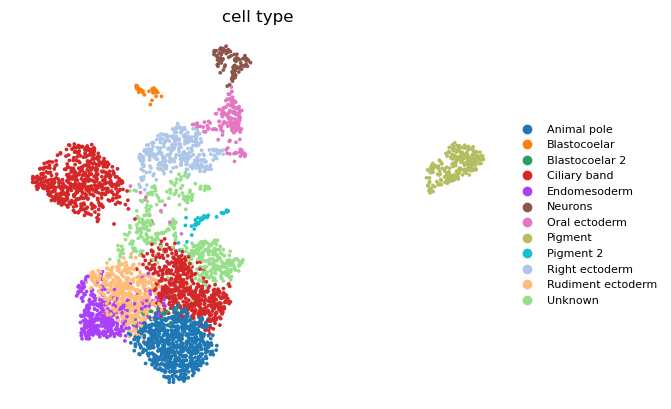

In [30]:
#create a UMAP labeled by clusters
cluster_annotation = {
    "0": "Animal pole",
    "1": "Ciliary band",
    "2": "Rudiment ectoderm",
    "3": "Endomesoderm",
    "4": "Ciliary band",
    "5": "Right ectoderm",
    "6": "Pigment",
    "7": "Unknown",
    "8": "Ciliary band",
    "9": "Oral ectoderm",
    "10": "Unknown",
    "11": "Neurons",
    "12": "Unknown",
    "13": "Pigment 2",
    "14": "Blastocoelar",
    "15": "Blastocoelar 2",
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
he48.obs["cell type"] = he48.obs["leiden"].map(cluster_annotation).astype("category")

#note, saving the UMAP creates a figure folder and saves the photo to the figure folder- figure folder removed for code access purposes in this repository
sc.pl.umap(
    he48,
    color="cell type",
    legend_loc="right margin",
    frameon=False,
    legend_fontsize=8,
    legend_fontoutline=2,
    save='cluster_labeled_UMAP.png'
)


categories: Animal pole, Blastocoelar, Blastocoelar 2, etc.
var_group_labels: Pigment, Animal Pole, Endomesoderm, etc.


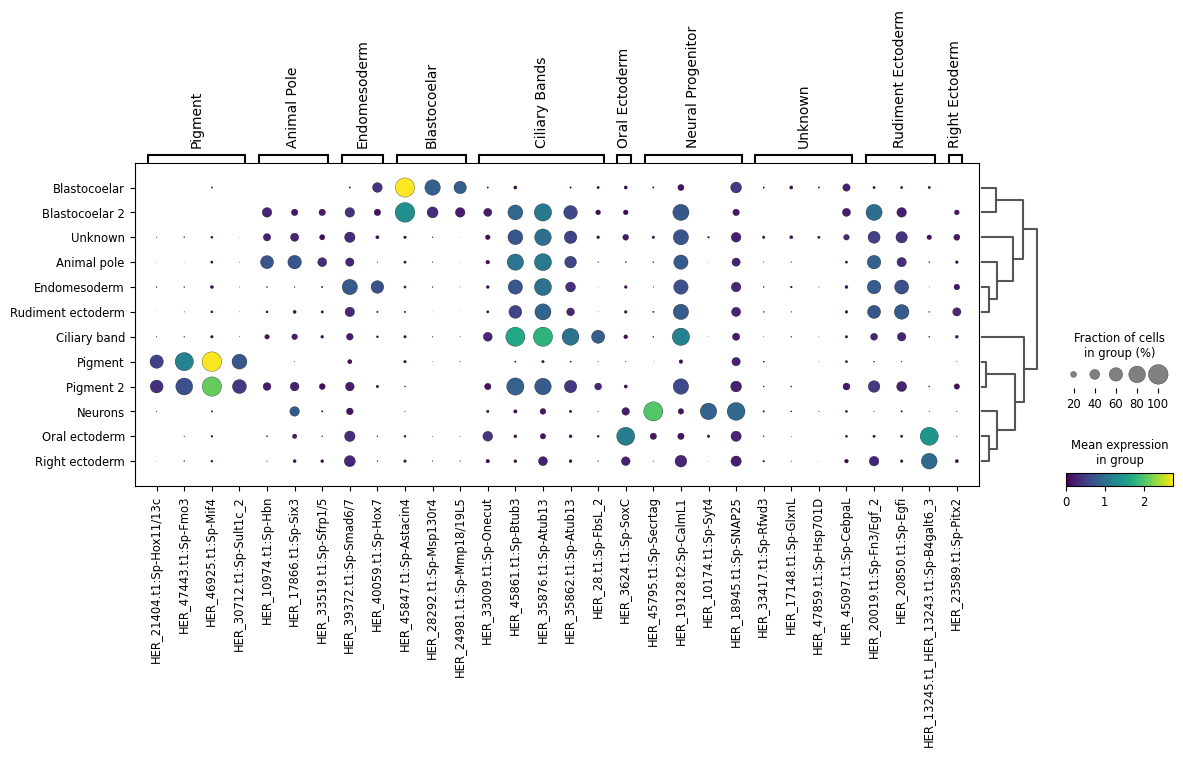

In [39]:
#list of known marker genes to compare in our dotplot
marker_genes = {
    "Pigment": ["HER_21404.t1:Sp-Hox11/13c", "HER_47443.t1:Sp-Fmo3", "HER_46925.t1:Sp-Mif4", "HER_30712.t1:Sp-Sult1c_2"],
    "Animal Pole": ["HER_10974.t1:Sp-Hbn", "HER_17866.t1:Sp-Six3", "HER_33519.t1:Sp-Sfrp1/5"],
    "Endomesoderm": ["HER_39372.t1:Sp-Smad6/7", "HER_40059.t1:Sp-Hox7"],
    "Blastocoelar": ["HER_45847.t1:Sp-Astacin4", "HER_28292.t1:Sp-Msp130r4", "HER_24981.t1:Sp-Mmp18/19L5"],
    "Ciliary Bands": ["HER_33009.t1:Sp-Onecut", "HER_45861.t1:Sp-Btub3", "HER_35876.t1:Sp-Atub13", "HER_35862.t1:Sp-Atub13", "HER_28.t1:Sp-FbsL_2"],
    "Oral Ectoderm": ["HER_3624.t1:Sp-SoxC"],
    "Neural Progenitor": ["HER_45795.t1:Sp-Secrtag", "HER_19128.t2:Sp-CalmL1", "HER_10174.t1:Sp-Syt4", "HER_18945.t1:Sp-SNAP25"],
    "Unknown": ["HER_33417.t1:Sp-Rfwd3", "HER_17148.t1:Sp-GlxnL", "HER_47859.t1:Sp-Hsp701D", "HER_45097.t1:Sp-CebpaL",],
    "Rudiment Ectoderm": ["HER_20019.t1:Sp-Fn3/Egf_2", "HER_20850.t1:Sp-Egfi", "HER_13245.t1_HER_13243.t1:Sp-B4galt6_3"],
    "Right Ectoderm": ["HER_23589.t1:Sp-Pitx2"],
}
#code to create a dotplot which shows the top genes by cluster compared against clusters labeled by known marker genes
sc.pl.dotplot(
    he48,
    marker_genes,
    groupby="cell type",
    cmap="viridis",
    dendrogram=True,
    save='markergenes_vs_cluster_dotplot.png'
)

## Hypothesis Test
To see that our clusters were different, we confirmed these using a Wilcoxon rank-sum test with the Benjamini-Hochberg correction. Code to perform this test for pigment and blastoceolar clusters are below.

In [ ]:
#get clusters of interest
pigment = he48[he48.obs.leiden == "6"].copy()
blastocoelar = he48[he48.obs.leiden == "14"].copy()
non6 = he48[he48.obs.leiden != "6"].copy()
non14 = he48[he48.obs.leiden != "14"].copy()

In [ ]:
#normalize the data
sc.pp.normalize_total(pigment, target_sum=1e6, layer = "counts")
sc.pp.normalize_total(blastocoelar, target_sum=1e6, layer = "counts")
sc.pp.normalize_total(non6, target_sum=1e6, layer = "counts")
sc.pp.normalize_total(non14, target_sum=1e6, layer = "counts")

In [ ]:
#put the data on a log scale
sc.pp.log1p(pigment, base = 2, layer = "counts")
sc.pp.log1p(blastocoelar, base = 2, layer = "counts")
sc.pp.log1p(non6, base = 2, layer = "counts")
sc.pp.log1p(non14, base = 2, layer = "counts")

In [ ]:
#Optional check: Look at a known marker gene for each cell type and plot a histogram by clusters of appearance
#sns.histplot(blastocoelar[:,"HER_45847.t1:Sp-Astacin4"].layers["counts"].flatten())
#sns.histplot(pigment[:,"HER_46925.t1:Sp-Mif4"].layers["counts"].flatten())

In [ ]:
# Confidence interval based on a t-test for the normalized, log2-transformed data for known pigment

# Mif4 in pigment vs. other cells
mif4_pigment = pigment[:,"HER_46925.t1:Sp-Mif4"].layers["counts"].flatten()  # Expression values in condition 1
mif4_other = non6[:,"HER_46925.t1:Sp-Mif4"].layers["counts"].flatten()  # Expression values in condition 2

mean_diff = np.mean(mif4_pigment) - np.mean(mif4_other)
se = np.sqrt(np.var(mif4_pigment, ddof=1)/len(mif4_pigment) + np.var(mif4_other, ddof=1)/len(mif4_other))
df = len(mif4_pigment) + len(mif4_other) - 2
t_crit = stats.t.ppf(0.975, df)  # 95% CI

ci_lower = mean_diff - t_crit * se
ci_upper = mean_diff + t_crit * se
print(f"95% CI: ({ci_lower}, {ci_upper})")

In [ ]:
# Confidence interval based on a t-test for the normalized, log2-transformed data for known blastoceolar marker

# astacin in blastocolar vs. other cells
astacin_blasto = blastocoelar[:,"HER_45847.t1:Sp-Astacin4"].layers["counts"].flatten()  # Expression values in condition 1
astacin_other = non14[:,"HER_45847.t1:Sp-Astacin4"].layers["counts"].flatten()  # Expression values in condition 2

mean_diff = np.mean(astacin_blasto) - np.mean(astacin_other)
se = np.sqrt(np.var(astacin_blasto, ddof=1)/len(astacin_blasto) + np.var(astacin_other, ddof=1)/len(astacin_other))
df = len(astacin_blasto) + len(astacin_other) - 2
t_crit = stats.t.ppf(0.975, df)  # 95% CI

ci_lower = mean_diff - t_crit * se
ci_upper = mean_diff + t_crit * se
print(f"95% CI: ({ci_lower}, {ci_upper})")

In [ ]:
#function to generalize the above examples
def diff_exp_CI(sample1, sample2, ci_level):
    mean_diff = np.mean(sample1) - np.mean(sample2)
    se = np.sqrt(np.var(sample1, ddof=1)/len(sample1) + np.var(sample2, ddof=1)/len(sample2))
    df = len(sample1) + len(sample2) - 2
    t_crit = stats.t.ppf(0.975, df)  # 95% CI

    ci_lower = mean_diff - t_crit * se
    ci_upper = mean_diff + t_crit * se
    
    return (ci_lower, ci_upper)